In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
import pandas as pd
import re
from pathlib import Path
import SimpleITK as sitk
import numpy as np
from torch.utils.data import Dataset, DataLoader
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
def normalize(img):
    max_value = img.max()
    min_value = img.min()
    
    return (img - min_value) / (max_value - min_value + 1e-8)

def image_pad_crop(img, mask, size, margin=1):
    if img.ndim == 3 and img.shape[2] == 1:
        non_black_flat = img[:,:,0] > 0
    elif img.ndim == 2:
        non_black_flat = img > 0
    else:
        non_black_flat = np.sum(img, axis=-1) > 0 if img.ndim == 3 else np.sum(img, axis=0) > 0 
        
    coords = np.argwhere(non_black_flat)

    if len(coords) == 0:
        if img.ndim == 3: # Assuming (H, W, C)
            h, w, _ = img.shape
        else: # (H, W)
            h, w = img.shape
        center_y, center_x = h // 2, w // 2
    else:
        y_min, x_min = coords.min(axis=0)
        y_max, x_max = coords.max(axis=0)

        if img.ndim == 3:
            h, w, _ = img.shape
        else:
            h, w = img.shape
            
        y_min = max(0, y_min - margin)
        x_min = max(0, x_min - margin)
        y_max = min(h - 1, y_max + margin)
        x_max = min(w - 1, x_max + margin)
        
        center_y = (y_min + y_max) // 2
        center_x = (x_min + x_max) // 2

    half_size = size // 2
    crop_start_y = center_y - half_size
    crop_end_y = center_y + half_size
    crop_start_x = center_x - half_size
    crop_end_x = center_x + half_size

    if img.ndim == 3: # (H, W, C)
        img_result = np.zeros((size, size, img.shape[2]), dtype=img.dtype)
    else: # (H, W)
        img_result = np.zeros((size, size), dtype=img.dtype)
        
    mask_result = np.zeros((size, size), dtype=mask.dtype)

    src_start_y = max(0, crop_start_y)
    src_end_y = min(h, crop_end_y) 
    src_start_x = max(0, crop_start_x)
    src_end_x = min(w, crop_end_x) 
    
    dest_start_y = max(0, -crop_start_y)
    dest_end_y = dest_start_y + (src_end_y - src_start_y)
    dest_start_x = max(0, -crop_start_x)
    dest_end_x = dest_start_x + (src_end_x - src_start_x)

    img_result[dest_start_y:dest_end_y, dest_start_x:dest_end_x] = img[src_start_y:src_end_y, src_start_x:src_end_x]
    mask_result[dest_start_y:dest_end_y, dest_start_x:dest_end_x] = mask[src_start_y:src_end_y, src_start_x:src_end_x]
    
    return img_result, mask_result

class BraTSDataset(Dataset):
    def __init__(self, data_list, transform=None, out_size=256):
        self.data_list = data_list
        self.transform = transform
        self.out_size = out_size
        
    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        z_current, img_path, mask_path = self.data_list[idx]
        
        full_image_volume = sitk.GetArrayFromImage(sitk.ReadImage(img_path)) 
        full_mask_volume = sitk.GetArrayFromImage(sitk.ReadImage(mask_path)) 

        total_slices = full_image_volume.shape[0]

        z_prev = max(0, z_current - 1)
        z_next = min(total_slices - 1, z_current + 1)

        image_prev = full_image_volume[z_prev]
        image_current = full_image_volume[z_current]
        image_next = full_image_volume[z_next]
        
        mask_data = full_mask_volume[z_current]

        image_prev_norm = normalize(image_prev)
        image_current_norm = normalize(image_current)
        image_next_norm = normalize(image_next)

        combined_image_3channel = np.stack([image_prev_norm, image_current_norm, image_next_norm], axis=-1) # (H, W, 3)

        image_new, mask_new = image_pad_crop(combined_image_3channel, mask_data, self.out_size)
        
        make_t = self.transform(image=image_new, mask=mask_new)
        image_tensor = make_t['image'] 
        mask_tensor = make_t['mask']
        
        return image_tensor.float(), mask_tensor.float().unsqueeze(0)

In [ ]:
train_transform = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.05, rotate_limit=15, p=0.5),
    A.ElasticTransform(alpha=120, sigma=120 * 0.05, alpha_affine=120 * 0.03, p=0.5),
    ToTensorV2(),
])

test_transform = A.Compose([
    ToTensorV2(),
])

def create_dataloader(batch_size=8):
    test_list_path = '~/test_files.csv'

    df = pd.read_csv(test_list_path)

    test_code_list = []
    for fname in df['filename']:
        test_num = re.search(r'BraTS-MEN-RT-([0-9]{4})', fname).group(1)
        test_code_list.append(test_num)
        
    data_path = '/data1/kerter/BraTS/Preprocessing/train/Normalize'

    base_path = Path(data_path)

    img_path = base_path / 'img'
    mask_path = base_path / 'mask'

    img_list = sorted(img_path.iterdir())
    mask_list = sorted(mask_path.iterdir())

    train_data_list, test_data_list = [], []
    test_loader_list = []

    for img_path, mask_path in zip(img_list, mask_list):
        mask = sitk.ReadImage(mask_path)
        mask_data = sitk.GetArrayFromImage(mask)
        
        code = re.search(r'([0-9]{4}).nii.gz', mask_path.name).group(1)
        
        for z, mask_slice in enumerate(mask_data):
            if mask_slice.sum() > 0:
                if code in test_code_list:
                    test_data_list.append((z, img_path, mask_path))
                else:
                    train_data_list.append((z, img_path, mask_path))
                    
        if code in test_code_list and len(test_data_list) > 0:
            test_dataset = BraTSDataset(test_data_list, transform=test_transform)
            test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, pin_memory=True, num_workers=8)
            
            test_loader_list.append(test_loader)
            test_data_list = []
    
    train_dataset = BraTSDataset(train_data_list, transform=train_transform)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True, num_workers=8)
    
    return train_loader, test_loader_list

In [5]:
train_loader, test_loader_list = create_dataloader(batch_size=2)

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

ACT_FUNC = nn.PReLU()

# 기존 ConvBlock을 ResidualConvBlock으로 확장합니다.
class ResidualConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super().__init__()
        self.conv_block = nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, stride=stride, bias=False),
            nn.BatchNorm2d(out_channels),
            ACT_FUNC,
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels)
        )
        self.relu = ACT_FUNC

        # Skip connection을 위한 1x1 conv (채널 수가 다를 경우 또는 stride가 1이 아닐 경우)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_channels != out_channels:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        return self.relu(self.conv_block(x) + self.shortcut(x)) # 잔차 연결 추가

class EncoderBlock(nn.Module):
    def __init__(self, in_channels, out_channels, dropout_p=0.2):
        super().__init__()
        # ConvBlock 대신 ResidualConvBlock 사용
        self.conv_block = ResidualConvBlock(in_channels, out_channels)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.dropout = nn.Dropout2d(p=dropout_p)

    def forward(self, x):
        x = self.conv_block(x)
        x = self.dropout(x)
        p = self.pool(x)
        return x, p

class DecoderBlock(nn.Module):
    def __init__(self, in_channels_decoder, in_channels_skip, out_channels, dropout_p=0.2):
        super().__init__()

        self.upsample = nn.ConvTranspose2d(in_channels_decoder, in_channels_decoder, kernel_size=2, stride=2)

        self.conv_block = ResidualConvBlock(in_channels_decoder + in_channels_skip, out_channels)
        self.dropout = nn.Dropout2d(p=dropout_p)

    def forward(self, x_decoder, x_skip):
        x_decoder_upsampled = self.upsample(x_decoder)
            
        x = torch.cat([x_decoder_upsampled, x_skip], dim=1)
        
        x = self.conv_block(x)
        x = self.dropout(x)
        return x

class AResUNet(nn.Module): # 클래스 이름 변경
    def __init__(self, in_channels=3, classes=1, dropout_rate=0.3):
        super().__init__()
        
        # 인코더 정의 (ResidualConvBlock 사용)
        self.enc1 = EncoderBlock(in_channels, 64, dropout_p=dropout_rate)
        self.enc2 = EncoderBlock(64, 128, dropout_p=dropout_rate)
        self.enc3 = EncoderBlock(128, 256, dropout_p=dropout_rate)
        self.enc4 = EncoderBlock(256, 512, dropout_p=dropout_rate)

        # 바닥 (Bottleneck) 부분 (ResidualConvBlock 사용)
        self.bottleneck = ResidualConvBlock(512, 1024)
        self.dropout_bottleneck = nn.Dropout2d(p=dropout_rate)

        # 디코더 정의 (AttentionBlock을 포함한 DecoderBlock 사용)
        self.dec4 = DecoderBlock(1024, 512, 512, dropout_p=dropout_rate)
        self.dec3 = DecoderBlock(512, 256, 256, dropout_p=dropout_rate)
        self.dec2 = DecoderBlock(256, 128, 128, dropout_p=dropout_rate)
        self.dec1 = DecoderBlock(128, 64, 64, dropout_p=dropout_rate)
        
        # 최종 출력 레이어
        self.final_conv = nn.Conv2d(64, classes, kernel_size=1)

    def forward(self, x):
        # 인코더 경로
        s1, p1 = self.enc1(x)
        s2, p2 = self.enc2(p1)
        s3, p3 = self.enc3(p2)
        s4, p4 = self.enc4(p3)

        # 바닥 (Bottleneck)
        b = self.bottleneck(p4)
        b = self.dropout_bottleneck(b)

        # 디코더 경로 (Attention 적용)
        d4 = self.dec4(b, s4)
        d3 = self.dec3(d4, s3)
        d2 = self.dec2(d3, s2)
        d1 = self.dec1(d2, s1)
        
        # 최종 출력
        output = self.final_conv(d1)
        
        return output

In [ ]:
# <셀 1>
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts

# 기본 설정
DEVICE = 'cuda:1' if torch.cuda.is_available() else 'cpu'
THRESHOLD = 0.5

print(f"사용 장치: {DEVICE}")

사용 장치: cuda:1


In [11]:
from tqdm import tqdm

def train_epoch(model, loader, optimizer, scheduler, criterion, device, batch_count=1):
    model.train()

    total_epoch_loss, total_epoch_dice = 0.0, 0.0
    num_batches = len(loader)
    
    tqdm_loader = tqdm(loader)
    
    optimizer.zero_grad()
    
    for i, (images, masks) in enumerate(tqdm_loader):
        images, masks = images.to(device, non_blocking=True), masks.to(device, non_blocking=True)
                
        logits = model(images)
        loss, dice = criterion(logits, masks)
        loss.backward()
        
        if scheduler:
            scheduler.step()
        
        if (i+1) % batch_count == 0 or (i+1) == num_batches:
            optimizer.step()
                
            optimizer.zero_grad()

        total_epoch_loss += loss.item()
        total_epoch_dice += dice.item()

    return total_epoch_loss / num_batches, total_epoch_dice / num_batches

In [12]:
def validate(model, loader_list, criterion, device):
    model.eval()

    total_loss, total_dice = 0.0, 0.0
    num_batches = len(loader_list)
    
    with torch.no_grad():
        for loader in tqdm(loader_list):
            logits, masks = [], []
            
            for image, mask in loader:
                image = image.to(device)

                logit = model(image)
                
                logits.append(logit.cpu())
                masks.append(mask)
            
            logits_3d = torch.cat(logits, dim=0).unsqueeze(0).to(device)
            masks_3d = torch.cat(masks, dim=0).unsqueeze(0).to(device)
            
            loss, dice = criterion(logits_3d, masks_3d)

            total_loss += loss.item()
            total_dice += dice.item()

    return total_loss / num_batches, total_dice / num_batches

In [13]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceFocalLoss(nn.Module):
    """
    Dice Loss와 Focal Loss를 결합한 손실 함수입니다.
    - Loss 계산: Soft-Dice Loss를 사용하여 미분 가능성을 확보합니다.
    - Score 측정: Hard-Dice Score를 사용하여 평가 지표의 직관성을 높입니다.
    """
    def __init__(self, focal_alpha=0.25, focal_gamma=2.0, dice_weight=0.5, threshold=0.5):
        super(DiceFocalLoss, self).__init__()
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.dice_weight = dice_weight
        self.threshold = threshold

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): 모델의 출력 로짓 (B, C, H, W).
            targets (torch.Tensor): 정답 마스크 (B, C, H, W).
        Returns:
            tuple[torch.Tensor, torch.Tensor]: (결합된 손실값, Threshold가 적용된 Dice 점수)
        """
        # --- 기본 변수 준비 ---
        targets = targets.float()
        # 훈련(Loss)에 사용할 부드러운 확률 값
        probs = torch.sigmoid(inputs)
        # 평가(Score)에 사용할 이진 마스크
        probs_mask = (probs > self.threshold).float()

        # --- Focal Loss 계산 ---
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.focal_alpha * (1 - pt)**self.focal_gamma * bce_loss
        focal_loss = focal_loss.mean()

        # --- Dice Loss 및 Score 계산 (종양이 있는 슬라이스에 대해서만) ---
        has_tumor = torch.sum(targets, dim=[1, 2, 3]) > 0

        if not has_tumor.any():
            dice_loss = torch.tensor(0.0, device=inputs.device)
            # [수정] 반환될 최종 점수도 1.0으로 설정
            dice_score_metric = torch.tensor(1.0, device=inputs.device)
        else:
            # 종양이 있는 슬라이스만 필터링
            positive_targets = targets[has_tumor]

            # 1. Loss 계산용 Soft-Dice (미분 가능해야 함)
            positive_probs = probs[has_tumor]
            intersection_soft = torch.sum(positive_probs * positive_targets)
            denominator_soft = torch.sum(positive_probs) + torch.sum(positive_targets)
            dice_score_soft = (2. * intersection_soft + 1e-6) / (denominator_soft + 1e-6)
            dice_loss = 1 - dice_score_soft

            # 2. Metric 측정용 Hard-Dice (Threshold 적용, 반환될 값)
            positive_probs_mask = probs_mask[has_tumor]
            intersection_hard = torch.sum(positive_probs_mask * positive_targets)
            denominator_hard = torch.sum(positive_probs_mask) + torch.sum(positive_targets)
            dice_score_metric = (2. * intersection_hard + 1e-6) / (denominator_hard + 1e-6)

        # --- 두 손실을 결합 ---
        combined_loss = (1 - self.dice_weight) * focal_loss + self.dice_weight * dice_loss
        
        # 손실값과 (Threshold가 적용된) Dice 점수를 함께 반환
        return combined_loss, dice_score_metric

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class DiceFocalLoss3D(nn.Module):
    """
    3D 데이터 (B, C, D, H, W)를 지원하는 Dice + Focal Loss 입니다.
    - Loss 계산: Soft-Dice Loss를 사용하여 미분 가능성을 확보합니다.
    - Score 측정: Hard-Dice Score를 사용하여 평가 지표의 직관성을 높입니다.
    """
    def __init__(self, focal_alpha=0.25, focal_gamma=2.0, dice_weight=0.5, threshold=0.5):
        super(DiceFocalLoss3D, self).__init__()
        self.focal_alpha = focal_alpha
        self.focal_gamma = focal_gamma
        self.dice_weight = dice_weight
        self.threshold = threshold

    def forward(self, inputs, targets):
        """
        Args:
            inputs (torch.Tensor): 모델의 출력 로짓 (B, C, D, H, W).
            targets (torch.Tensor): 정답 마스크 (B, C, D, H, W).
        Returns:
            tuple[torch.Tensor, torch.Tensor]: (결합된 손실값, Threshold가 적용된 Dice 점수)
        """
        # --- 기본 변수 준비 ---
        targets = targets.float()
        # 훈련(Loss)에 사용할 부드러운 확률 값
        probs = torch.sigmoid(inputs)
        # 평가(Score)에 사용할 이진 마스크
        probs_mask = (probs > self.threshold).float()

        # --- Focal Loss 계산 (전체 3D 볼륨에 대해) ---
        bce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-bce_loss)
        focal_loss = self.focal_alpha * (1 - pt)**self.focal_gamma * bce_loss
        focal_loss = focal_loss.mean()

        # --- Dice Loss 및 Score 계산 (종양이 있는 3D 볼륨에 대해서만) ---
        # 3D에 맞게 합산 차원 변경: (C, D, H, W) -> dim=[1, 2, 3, 4]
        has_tumor = torch.sum(targets, dim=[1, 2, 3, 4]) > 0

        if not has_tumor.any():
            dice_loss = torch.tensor(0.0, device=inputs.device)
            dice_score_metric = torch.tensor(1.0, device=inputs.device)
        else:
            # 종양이 있는 3D 볼륨만 필터링
            positive_targets = targets[has_tumor]

            # 1. Loss 계산용 Soft-Dice (미분 가능해야 함)
            positive_probs = probs[has_tumor]
            intersection_soft = torch.sum(positive_probs * positive_targets)
            denominator_soft = torch.sum(positive_probs) + torch.sum(positive_targets)
            dice_score_soft = (2. * intersection_soft + 1e-6) / (denominator_soft + 1e-6)
            dice_loss = 1 - dice_score_soft

            # 2. Metric 측정용 Hard-Dice (Threshold 적용, 반환될 값)
            positive_probs_mask = probs_mask[has_tumor]
            intersection_hard = torch.sum(positive_probs_mask * positive_targets)
            denominator_hard = torch.sum(positive_probs_mask) + torch.sum(positive_targets)
            dice_score_metric = (2. * intersection_hard + 1e-6) / (denominator_hard + 1e-6)

        # --- 두 손실을 결합 ---
        combined_loss = (1 - self.dice_weight) * focal_loss + self.dice_weight * dice_loss
        
        # 손실값과 (Threshold가 적용된) Dice 점수를 함께 반환
        return combined_loss, dice_score_metric

--- 최종 학습을 시작합니다 ---
'latest_checkpoint_new.pth'에서 체크포인트를 불러옵니다.
Epoch 95부터 학습을 재개합니다.
이전 최고 Dice 점수: 0.7709

--- 최종 학습 Epoch 95/100 ---


100%|██████████| 42/42 [00:46<00:00,  1.10s/it]


Train Loss: 0.0625, Train Dice: 0.8779
Valid Loss: 0.1235, Valid Dice: 0.7571
  >> Epoch 95의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 Epoch 96/100 ---


100%|██████████| 42/42 [00:51<00:00,  1.22s/it]


Train Loss: 0.0620, Train Dice: 0.8789
Valid Loss: 0.1330, Valid Dice: 0.7385
  >> Epoch 96의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 Epoch 97/100 ---


100%|██████████| 42/42 [00:48<00:00,  1.16s/it]


Train Loss: 0.0606, Train Dice: 0.8817
Valid Loss: 0.1285, Valid Dice: 0.7470
  >> Epoch 97의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 Epoch 98/100 ---


100%|██████████| 42/42 [00:35<00:00,  1.19it/s]


Train Loss: 0.0593, Train Dice: 0.8842
Valid Loss: 0.1191, Valid Dice: 0.7655
  >> Epoch 98의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 Epoch 99/100 ---


100%|██████████| 42/42 [00:32<00:00,  1.27it/s]


Train Loss: 0.0589, Train Dice: 0.8850
Valid Loss: 0.1198, Valid Dice: 0.7640
  >> Epoch 99의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 Epoch 100/100 ---


100%|██████████| 42/42 [00:55<00:00,  1.32s/it]


Train Loss: 0.0592, Train Dice: 0.8844
Valid Loss: 0.1213, Valid Dice: 0.7615
  >> Epoch 100의 상태를 'latest_checkpoint_new.pth'에 저장했습니다.

--- 최종 학습 완료 ---
최고 검증 Dice: 0.7709


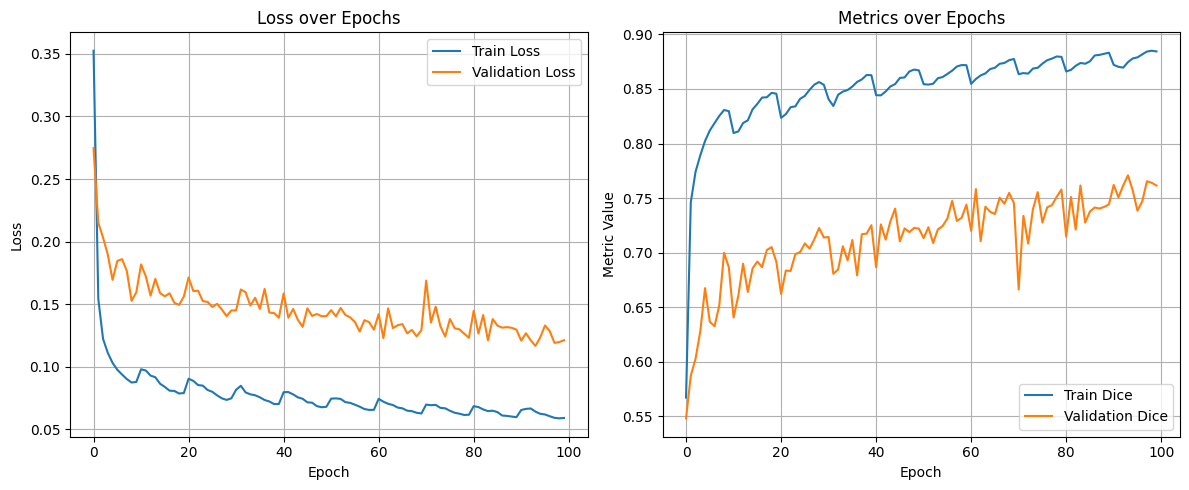

In [15]:
import torch
import torch.optim as optim
from torch.optim.lr_scheduler import CosineAnnealingWarmRestarts
import os
import matplotlib.pyplot as plt

# 최적 하이퍼파라미터
best_lr = 1e-4
best_wd = 5e-05
best_do = 0.15

print("--- 최종 학습을 시작합니다 ---")

# --- 최종 학습 설정 ---
FINAL_EPOCHS = 100
T_0 = 10

# --- 체크포인트 파일 경로 설정 ---
CHECKPOINT_PATH = 'latest_checkpoint_new.pth'

# 모델, 옵티마이저, 스케줄러 초기화
final_model = AResUNet(dropout_rate=best_do).to(DEVICE)
optimizer = optim.AdamW(final_model.parameters(), lr=best_lr, weight_decay=best_wd)
scheduler = CosineAnnealingWarmRestarts(optimizer, T_0=T_0 * len(train_loader))

criterion = DiceFocalLoss()
criterion_val = DiceFocalLoss3D()

# --- 이어하기를 위한 변수 초기화 ---
start_epoch = 1
best_dice = 0.0
history = {
    'train_loss': [],
    'train_dice': [],
    'val_loss': [],
    'val_dice': []
}

# --- 체크포인트 파일이 존재하면 불러오기 ---
if os.path.exists(CHECKPOINT_PATH):
    print(f"'{CHECKPOINT_PATH}'에서 체크포인트를 불러옵니다.")
    checkpoint = torch.load(CHECKPOINT_PATH)
    
    final_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    best_dice = checkpoint['best_dice']
    history = checkpoint['history']
    
    print(f"Epoch {start_epoch}부터 학습을 재개합니다.")
    print(f"이전 최고 Dice 점수: {best_dice:.4f}")

# 학습 루프
for epoch in range(start_epoch, FINAL_EPOCHS + 1):
    print(f"\n--- 최종 학습 Epoch {epoch}/{FINAL_EPOCHS} ---")
    
    train_loss, train_dice = train_epoch(final_model, train_loader, optimizer, scheduler, criterion, DEVICE, batch_count=8)
    val_loss, val_dice = validate(final_model, test_loader_list, criterion_val, DEVICE)

    history['train_loss'].append(train_loss)
    history['train_dice'].append(train_dice)
    history['val_loss'].append(val_loss)
    history['val_dice'].append(val_dice)

    print(f"Train Loss: {train_loss:.4f}, Train Dice: {train_dice:.4f}"
          f"\nValid Loss: {val_loss:.4f}, Valid Dice: {val_dice:.4f}")

    is_best = val_dice > best_dice
    if is_best:
        best_dice = val_dice
        # 최고 성능 모델 저장
        torch.save(final_model.state_dict(), 'best_model_new.pth')
        print(f"  >> 새로운 최고 성능 달성! (Dice: {best_dice:.4f}). 'best_model_new.pth'에 모델을 저장합니다.")

    # --- 현재 학습 상태를 체크포인트로 저장 ---
    # 최고 성능 여부와 관계없이 매 에포크마다 저장하여 예기치 못한 중단에 대비합니다.
    torch.save({
        'epoch': epoch,
        'model_state_dict': final_model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'best_dice': best_dice,
        'history': history
    }, CHECKPOINT_PATH)
    print(f"  >> Epoch {epoch}의 상태를 '{CHECKPOINT_PATH}'에 저장했습니다.") # 저장 확인 메시지 (필요시 활성화)


print("\n--- 최종 학습 완료 ---")
print(f"최고 검증 Dice: {best_dice:.4f}")

# 학습 결과 그래프 그리기
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(history['train_dice'], label='Train Dice')
plt.plot(history['val_dice'], label='Validation Dice')
plt.title('Metrics over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Metric Value')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()